In [1]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

/Users/arezoobybordi/miniforge3/envs/ninen/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

#### **Run after**

In [2]:
import pandas as pd
#pd.DataFrame(terra_data, index= v1['ids']). to_csv("id_added_teratoxin_snekmer.csv")

In [3]:
train_df = pd.read_csv("All_Toxins_v4.csv")

In [4]:
full_df = pd.read_csv('https://raw.githubusercontent.com/weigangq/cono-models/main/data/All_Toxins_v4.csv')
sup = pd.read_csv('summary.csv')
merged_df = pd.merge(full_df, sup, left_on='NewNamev3', right_on='sequence', how='inner')
merged_df = merged_df[merged_df['definitive_pred'] != 'UNKNOWN']

In [5]:
merged_df.head()

,ToxinName,NewNamev2,NewNamev3,Signal,Pre,Mature,Post,Framework,Framework Confirmation,Framework Structure,sequence,hmm_pred,pssm_pred,definitive_pred
1,Cje_7Cys.2,Cje3_Novel,Cje3_Novel,MMLSFVVLISISVSMA,NaN,WLVPYGQLSVGIRSEEELENCQTDEVCGMVNYRNVTFCKCGNVGCP...,NaN,Novel,novel,C-C-C-C-C-C-C,Cje3_Novel,UNKNOWN,A,A
2,Cje_7Cys.3,Cje4_Novel,Cje4_Novel,MKAPAVLAIILGSFTLLHRSPGTDA,NaN,ISDDCQECKTDCERVIASCPDFKCSYGISTVLPCRLLLLAMRNIPK...,NaN,Novel,novel,C-C-C-C-C-C-C,Cje4_Novel,UNKNOWN,A,A
3,Cje22.2,Cje2_22,Cje2_22,MKVLFVLAMVLVTLCLG,RRMRR,DIIEDVCNNCTVSCQWVITNEGTTLCPSGFCDEPAAFCRNLKFNMD...,K,XXII,22,C-C-C-C-C-C-C-C,Cje2_22,UNKNOWN,M,M
4,Cje22.3,Cje3_22,Cje3_22,MKLSTAFVAILGLTASLCQSSG,NaN,ADTLSMECIICKWDCEDLVTSCANNDCGPNVSTKKKCDQLVTQMEM...,G,XXII,22,C-C-C-C-C-C-C-C,Cje3_22,UNKNOWN,M,M
6,Cje6.1,Cje1_6,Cje1_6,MRPLLVFVLVISVSLVFSIA,EDMPNHGDDSVASITEDQARKHKRNSKKDFDLDSLR,YENGCSIYCLSNDMCCRGSKCRDVNGIQKCVTENDFL,GK,VI/VII,6 and 7,C-C-CC-C-C,Cje1_6,UNKNOWN,O1,O1


In [6]:
# place needs to be changed
terra_data = merged_df

In [27]:
import numpy as np
len(np.unique(merged_df['Framework Confirmation']))

12

In [55]:
len(np.unique(merged_df['definitive_pred']))

30

In [103]:
np.unique(merged_df['definitive_pred'])

array(['A', 'CONFLICT Conkunitzin and A', 'CONFLICT Conkunitzin and L',
       'CONFLICT Conkunitzin and M', 'CONFLICT Conkunitzin and O1',
       'CONFLICT Conopressin-Conophysin and O1', 'CONFLICT D and A',
       'CONFLICT D and M', 'CONFLICT H and O1', 'CONFLICT I1 and O1',
       'CONFLICT I3 and A', 'CONFLICT I3 and O1', 'CONFLICT N and O1',
       'CONFLICT O2 and O1', 'CONFLICT P and A', 'CONFLICT P and M',
       'Conkunitzin', 'Conopressin-Conophysin', 'D', 'H', 'I1', 'I3', 'L',
       'M', 'N', 'O1', 'O2', 'O2/Contryphan', 'P', 'R'], dtype=object)

In [9]:
train_data = [(tuple(list(x))[1], tuple(list(x))[0])  for x in list(merged_df[['Mature','ToxinName']].values)]

In [10]:
dummy_train = train_data

In [11]:
tr_batch_labels, tr_batch_strs, tr_batch_tokens = batch_converter(dummy_train)
tr_batch_lens = (tr_batch_tokens != alphabet.padding_idx).sum(1)


In [12]:
# Extract per-residue representations (on CPU)
with torch.no_grad():
    tr_results = model(tr_batch_tokens, repr_layers=[33], return_contacts=False)

In [13]:
tr_token_representations = tr_results["representations"][33]

In [14]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
tr_sequence_representations = []
for i, tokens_len in enumerate(tr_batch_lens):
    tr_sequence_representations.append(tr_token_representations[i, 1 : tokens_len - 1].mean(0))


In [16]:
x = [tensor.numpy() for tensor in tr_sequence_representations]

In [17]:
import numpy as np

In [18]:
np.shape(x)

(651, 1280)

In [19]:
terra_data = x

In [28]:
type(terra_data)

numpy.ndarray

In [20]:
terra_data = np.array(terra_data)

#### **PCA:  95% variance explained.**

In [21]:
import numpy as np
from sklearn.decomposition import PCA


# Perform PCA for different numbers of components
n_components = range(1, terra_data.shape[0] + 1)
variance_explained = []
#total_variance = np.sum(np.var(reshaped_data, axis=0))

for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(terra_data)
    variance_explained.append(np.sum(pca.explained_variance_ratio_))

    # Check if 95% of total variance explained
    if variance_explained[-1] >= 0.95:
        print(f"Number of components needed to explain 95% variance: {n}")
        break

# Print the variance explained for each number of components
for i, var in enumerate(variance_explained):
    print(f"Components: {i+1}, Variance explained: {var:.4f}")

Number of components needed to explain 95% variance: 50
Components: 1, Variance explained: 0.4202
Components: 2, Variance explained: 0.5278
Components: 3, Variance explained: 0.5983
Components: 4, Variance explained: 0.6310
Components: 5, Variance explained: 0.6611
Components: 6, Variance explained: 0.6873
Components: 7, Variance explained: 0.7108
Components: 8, Variance explained: 0.7304
Components: 9, Variance explained: 0.7481
Components: 10, Variance explained: 0.7643
Components: 11, Variance explained: 0.7790
Components: 12, Variance explained: 0.7908
Components: 13, Variance explained: 0.8024
Components: 14, Variance explained: 0.8131
Components: 15, Variance explained: 0.8232
Components: 16, Variance explained: 0.8324
Components: 17, Variance explained: 0.8409
Components: 18, Variance explained: 0.8483
Components: 19, Variance explained: 0.8550
Components: 20, Variance explained: 0.8611
Components: 21, Variance explained: 0.8667
Components: 22, Variance explained: 0.8722
Compone

##### **Kmeans: Continue with components giving 95% explained variance, i.e. 64 PCs**

In [74]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
#transformed_pca_data = pca.fit_transform(terra_data)

In [75]:
pca.fit(terra_data)

PCA(n_components=50)

In [76]:
transformed_pca_data = pca.fit_transform(terra_data)

### KMeans with number of clusters 30

In [120]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=30, random_state=42).fit(transformed_pca_data)

In [121]:
predicted = kmeans.predict(transformed_pca_data)

In [122]:
merged_df.head()

,ToxinName,NewNamev2,NewNamev3,Signal,Pre,Mature,Post,Framework,Framework Confirmation,Framework Structure,sequence,hmm_pred,pssm_pred,definitive_pred
1,Cje_7Cys.2,Cje3_Novel,Cje3_Novel,MMLSFVVLISISVSMA,NaN,WLVPYGQLSVGIRSEEELENCQTDEVCGMVNYRNVTFCKCGNVGCP...,NaN,Novel,novel,C-C-C-C-C-C-C,Cje3_Novel,UNKNOWN,A,A
2,Cje_7Cys.3,Cje4_Novel,Cje4_Novel,MKAPAVLAIILGSFTLLHRSPGTDA,NaN,ISDDCQECKTDCERVIASCPDFKCSYGISTVLPCRLLLLAMRNIPK...,NaN,Novel,novel,C-C-C-C-C-C-C,Cje4_Novel,UNKNOWN,A,A
3,Cje22.2,Cje2_22,Cje2_22,MKVLFVLAMVLVTLCLG,RRMRR,DIIEDVCNNCTVSCQWVITNEGTTLCPSGFCDEPAAFCRNLKFNMD...,K,XXII,22,C-C-C-C-C-C-C-C,Cje2_22,UNKNOWN,M,M
4,Cje22.3,Cje3_22,Cje3_22,MKLSTAFVAILGLTASLCQSSG,NaN,ADTLSMECIICKWDCEDLVTSCANNDCGPNVSTKKKCDQLVTQMEM...,G,XXII,22,C-C-C-C-C-C-C-C,Cje3_22,UNKNOWN,M,M
6,Cje6.1,Cje1_6,Cje1_6,MRPLLVFVLVISVSLVFSIA,EDMPNHGDDSVASITEDQARKHKRNSKKDFDLDSLR,YENGCSIYCLSNDMCCRGSKCRDVNGIQKCVTENDFL,GK,VI/VII,6 and 7,C-C-CC-C-C,Cje1_6,UNKNOWN,O1,O1


In [123]:
superfm = list(merged_df['definitive_pred'])

In [124]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Create a DataFrame with the data
df = pd.DataFrame({'Predicted': predicted, 'superfamily': superfm})

In [125]:
# Create a contingency table
contingency_table = pd.crosstab(df['Predicted'], df['superfamily'])

In [126]:
# Display the contingency table
print("Contingency Table:")
print(contingency_table)

Contingency Table:
superfamily   A  CONFLICT Conkunitzin and A  CONFLICT Conkunitzin and L  \
Predicted                                                                 
0             9                           0                           0   
1             1                           2                           0   
2            71                           0                           0   
3             0                           0                           0   
4             0                           0                           0   
5             0                           0                           0   
6             2                           0                           0   
7             0                           0                           0   
8             0                           0                           0   
9             6                           0                           0   
10            0                           0                           0   
11    

In [127]:
import matplotlib.pyplot as plt

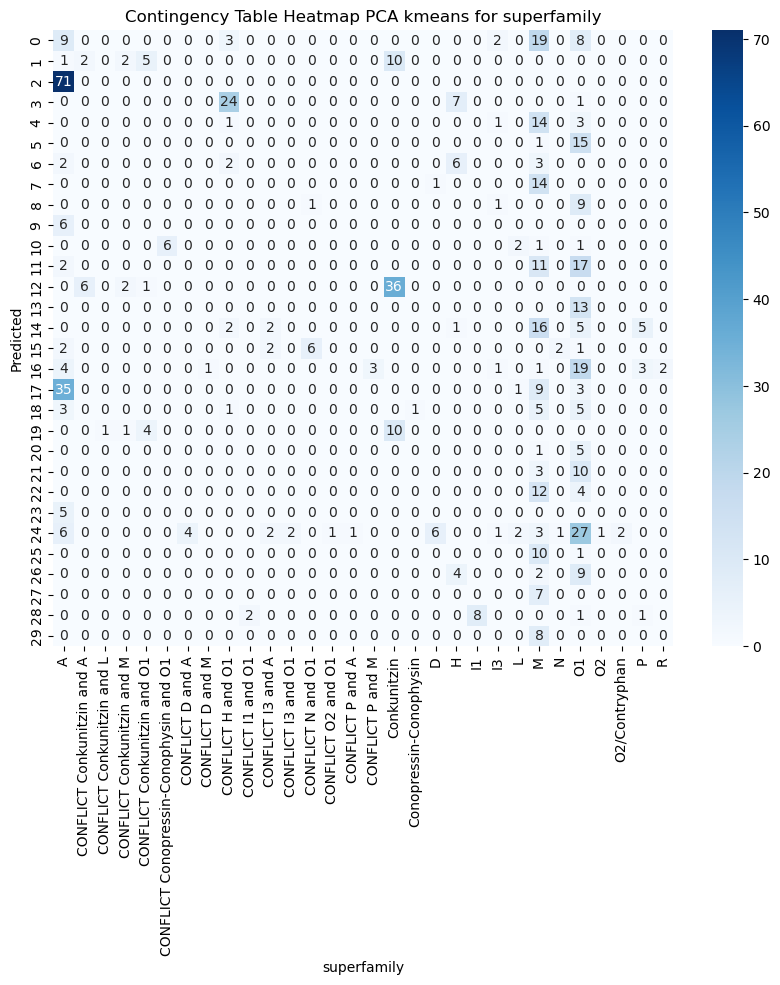

In [128]:
# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Contingency Table Heatmap PCA kmeans for superfamily')
plt.show()


#### **UMAP on teratoxin values with snekmer features**

In [113]:
import plotly.express as px


In [114]:
features= terra_data

In [115]:
features = pd.DataFrame(features, index=merged_df['ToxinName'])

In [116]:
from umap import UMAP
import plotly.express as px



#features = terra_data

umap_2d = UMAP(n_components=2, init='random', random_state=0)
umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(features)
proj_3d = umap_3d.fit_transform(features)


/Users/arezoobybordi/miniforge3/envs/ninen/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/arezoobybordi/miniforge3/envs/ninen/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### clusters with 30 clusters

In [129]:
import numpy as np
import pandas as pd
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Perform UMAP dimensionality reduction
umap = UMAP(n_components=3, random_state=42)
umap_embedding = umap.fit_transform(terra_data)

# Perform K-means clustering with the current number of clusters
kmeans = KMeans(n_clusters=30, random_state=42)
labels = kmeans.fit_predict(umap_embedding)

/Users/arezoobybordi/miniforge3/envs/ninen/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [130]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Create a DataFrame with the data
df = pd.DataFrame({'Predicted': labels, 'superfamily': superfm })
contingency_table = pd.crosstab(df['Predicted'], df['superfamily'])
# Display the contingency table
print("Contingency Table of UMAP for superfamily:")
print(contingency_table)


Contingency Table of UMAP for superfamily:
superfamily   A  CONFLICT Conkunitzin and A  CONFLICT Conkunitzin and L  \
Predicted                                                                 
0             7                           0                           0   
1             0                           6                           1   
2            28                           0                           0   
3             0                           0                           0   
4             5                           0                           0   
5             0                           0                           0   
6             4                           0                           0   
7             4                           0                           0   
8             0                           0                           0   
9             0                           0                           0   
10            0                           0              

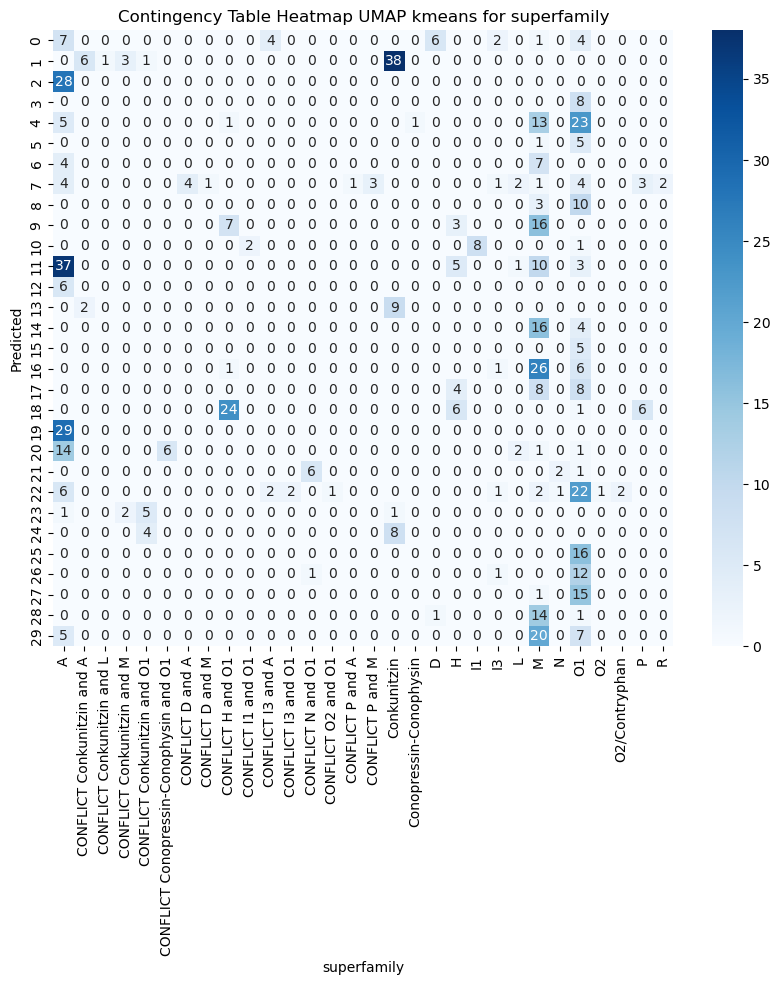

In [131]:
# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Contingency Table Heatmap UMAP kmeans for superfamily')
plt.show()
